# Emotion Detection

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob #glob is used to create list of available data
import cv2 #for working on images
import random # for random numbers
import os
%matplotlib inline 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D 
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version : ", tf.__version__)

Tensorflow version :  2.17.0


## Exploring dataset

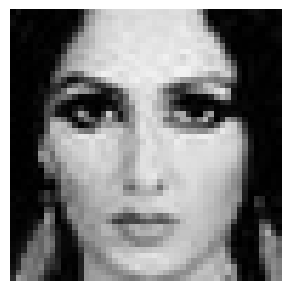

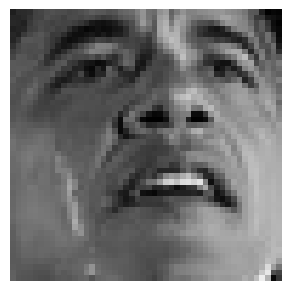

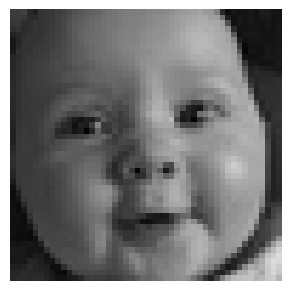

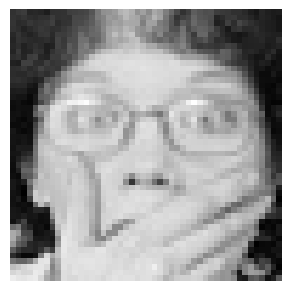

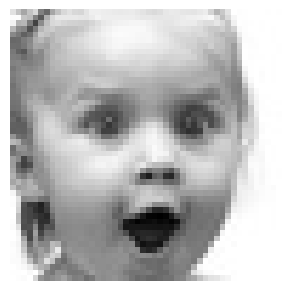

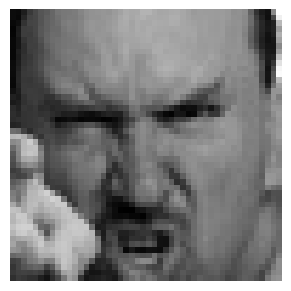

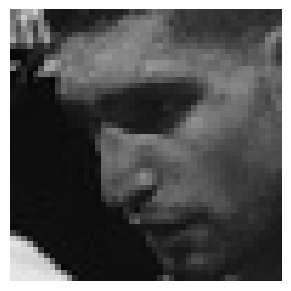

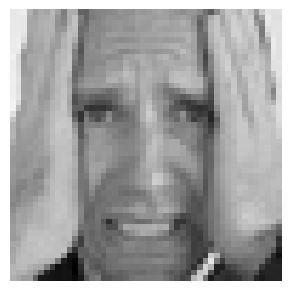

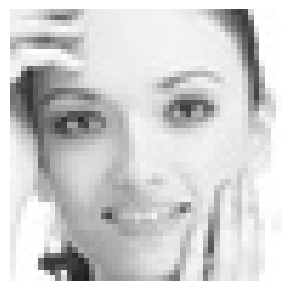

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size, img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size, img_size), 
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Defining Models

In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 48, 1)     │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 48, 48, 128)   │        1,280 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_2         │ (None, 48, 48, 128)   │          512 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation_2 (Activation)     │ (None, 48, 48, 128)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 24, 24, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_2 (Dropout)           │ (None, 24, 24, 128)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 73728)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 256)           │   18,874,624 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_3         │ (None, 256)           │        1,024 │
│ (BatchNormalization)          │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ activation_3 (Activation)     │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_3 (Dropout)           │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 7)             │        1,799 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## Initializing the model

In [9]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

# Training the Model

In [10]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15


C:\Users\aditi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3325 - loss: 1.8143
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 198s 435ms/step - accuracy: 0.3326 - loss: 1.8139 - val_accuracy: 0.3094 - val_loss: 1.7618
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:40 359ms/step - accuracy: 0.5156 - loss: 1.3219
Epoch 2: saving model to model_weights.weights.h5


C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5156 - loss: 1.3219 - val_accuracy: 0.1000 - val_loss: 2.1836
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4853 - loss: 1.3542
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 186s 414ms/step - accuracy: 0.4853 - loss: 1.3541 - val_accuracy: 0.4141 - val_loss: 1.5747
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:53 389ms/step - accuracy: 0.5938 - loss: 1.1391
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.1391 - val_accuracy: 0.2000 - val_loss: 2.0839
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5645 - loss: 1.1716
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 388ms/step - accuracy: 0.5645 - loss: 1.1717 - val_accuracy: 0.3996 - val_loss: 1.5176
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:59 402ms/step - accuracy: 0.4531 - loss: 1.4544
Epoch 6: saving mo

## Model Evaluation

In [11]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.4783 - loss: 1.5867


[1.6144397258758545, 0.4718584418296814]

## Plotting Loss

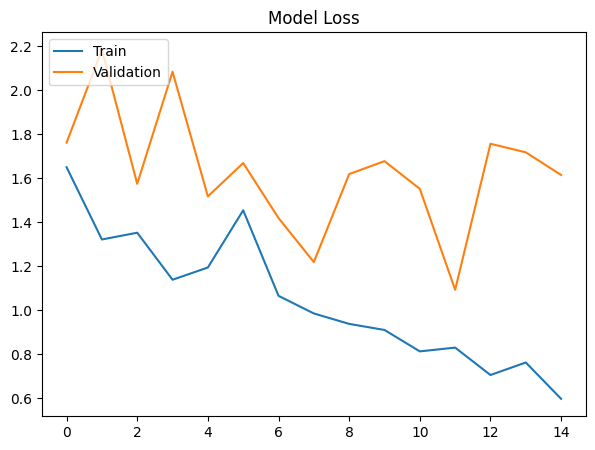

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top = 0.9,bottom = 0.1,right = 0.95,left = 0.1,hspace = 0.25,wspace = 0.35)

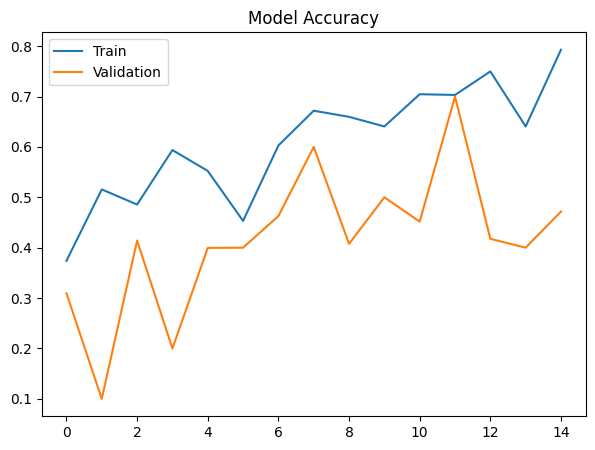

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top = 0.9,bottom = 0.1,right = 0.95,left = 0.1,hspace = 0.25,wspace = 0.35)

## Saving Model

In [14]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)